In [1]:
from flows import RealNVP, LightningINN
from autoencoders import VanillaVAE, LightningAutoEncoder
from utils import BoidImagesDataset, train_transform, simple_train_transform

import torch
from torch.utils.data import DataLoader
import lightning as L

In [2]:
train_data_set = BoidImagesDataset("boid_data", transform=simple_train_transform)
train_loader = DataLoader(train_data_set, 100, shuffle=True)

In [14]:
lvae = LightningAutoEncoder.load_from_checkpoint("autoencoder.ckpt", autoencoder_class=VanillaVAE, in_channels=3, latent_dim=500)
vae=lvae.autoencoder

In [25]:
def flat_encode(X):
    if len(X.shape) == 4:
        return (X.view(X.shape[0], -1).to('cuda'),)
    
    else:
        return (X.view(-1).to('cuda'),)

In [15]:
real_NVP = RealNVP(8, 200, 5, 500)
lightning_inn = LightningINN(inn=real_NVP, encoder=vae.encode)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | inn  | RealNVP | 1.4 M 
---------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.680     Total estimated model params size (MB)
c:\Users\dh99\Desktop\GNN\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 173:  92%|█████████▏| 183/200 [00:09<00:00, 19.42it/s, v_num=5]

Time limit reached. Elapsed time is 0:30:00. Signaling Trainer to stop.


Epoch 173:  92%|█████████▏| 184/200 [00:09<00:00, 19.26it/s, v_num=5]


In [26]:
real_NVP = RealNVP(8, 200, 5, 3*64*64)
lightning_inn = LightningINN(inn=real_NVP, encoder=flat_encode)

In [27]:
trainer = L.Trainer(max_time={"minutes": 30})
trainer.fit(model=lightning_inn, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type    | Params
---------------------------------
0 | inn  | RealNVP | 25.0 M
---------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
99.984    Total estimated model params size (MB)


Epoch 156:  59%|█████▉    | 118/200 [00:05<00:04, 19.76it/s, v_num=7]

Time limit reached. Elapsed time is 0:30:00. Signaling Trainer to stop.


Epoch 156:  60%|█████▉    | 119/200 [00:07<00:04, 16.20it/s, v_num=7]


In [26]:
params, img = None, None

for x in train_data_set:
    params, img = x
    break

In [27]:
img = img.cuda()
img.shape

enc, _ = vae.encode(img.reshape(1, 3, 64, 64))

print(enc.shape)

torch.Size([1, 500])


In [3]:
real_NVP = RealNVP(8, 200, 5, 500).cuda()
model = LightningINN.load_from_checkpoint("realnvp.ckpt", inn=real_NVP, encoder=vae.encode)


In [65]:

print(real_NVP.inverse(torch.randn((1, 8), device='cuda'), enc))
print(params)


tensor([[257.7860,   4.0855,   2.6874,   1.1757,   4.8930,  20.1110,  51.2120,
           0.9776]], device='cuda:0', grad_fn=<CatBackward0>)
[485.          0.          1.5276697   1.8295051   2.996073   20.
  58.693592    2.2492437]


In [18]:
device='cuda'

import tqdm

In [20]:
test_data_set = BoidImagesDataset("boid_test", transform=simple_train_transform)
test_loader = DataLoader(test_data_set, 100, shuffle=False)

#real_NVP.eval()
val_loss = 0

for batch_idx, data in enumerate(test_loader):
    if isinstance(data, list):
        if len(data) > 1:
            cond_data = data[1].float()
            cond_data = cond_data.to(device)

            cond_data = vae.encode(cond_data)[0]
        else:
            cond_data = None

        data = data[0]
    data = data.to(device)
    with torch.no_grad():
                          
        size = data.shape[0]
        z = data
        log_det_jac = 0
        for block in real_NVP.coupling_blocks:
            block = block.to(device)
            log_det_jac += torch.sum(block.get_transforms(z[:, :block.upper], cond_data)[0])
            z = block(z, cond_data)
            
        loss = ( ( torch.sum(torch.square(z)) / 2 ) - log_det_jac )
        
        val_loss += loss

print(val_loss / len(test_loader.dataset))

tensor(12.6340, device='cuda:0')


In [31]:
import numpy as np
positions = np.zeros((len(test_data_set), 8))
vae.eval()
real_NVP = real_NVP.to(device)
for i, instance in enumerate(test_data_set):

    params, img = instance
    
    cond = img.to(device)
    #cond = vanilla_VAE.encode(cond.reshape(1, 3, 64, 64))[0]
    cond = flat_encode(cond)[0]

    z = real_NVP.forward(torch.from_numpy(params.reshape(1, 8)).to(device), cond.reshape(1, -1)).detach().cpu()

    positions[i] = z



FileNotFoundError: [Errno 2] No such file or directory: 'boid_test/images/img5000.png'

Epoch 0:   0%|          | 0/200 [50:15<?, ?it/s]


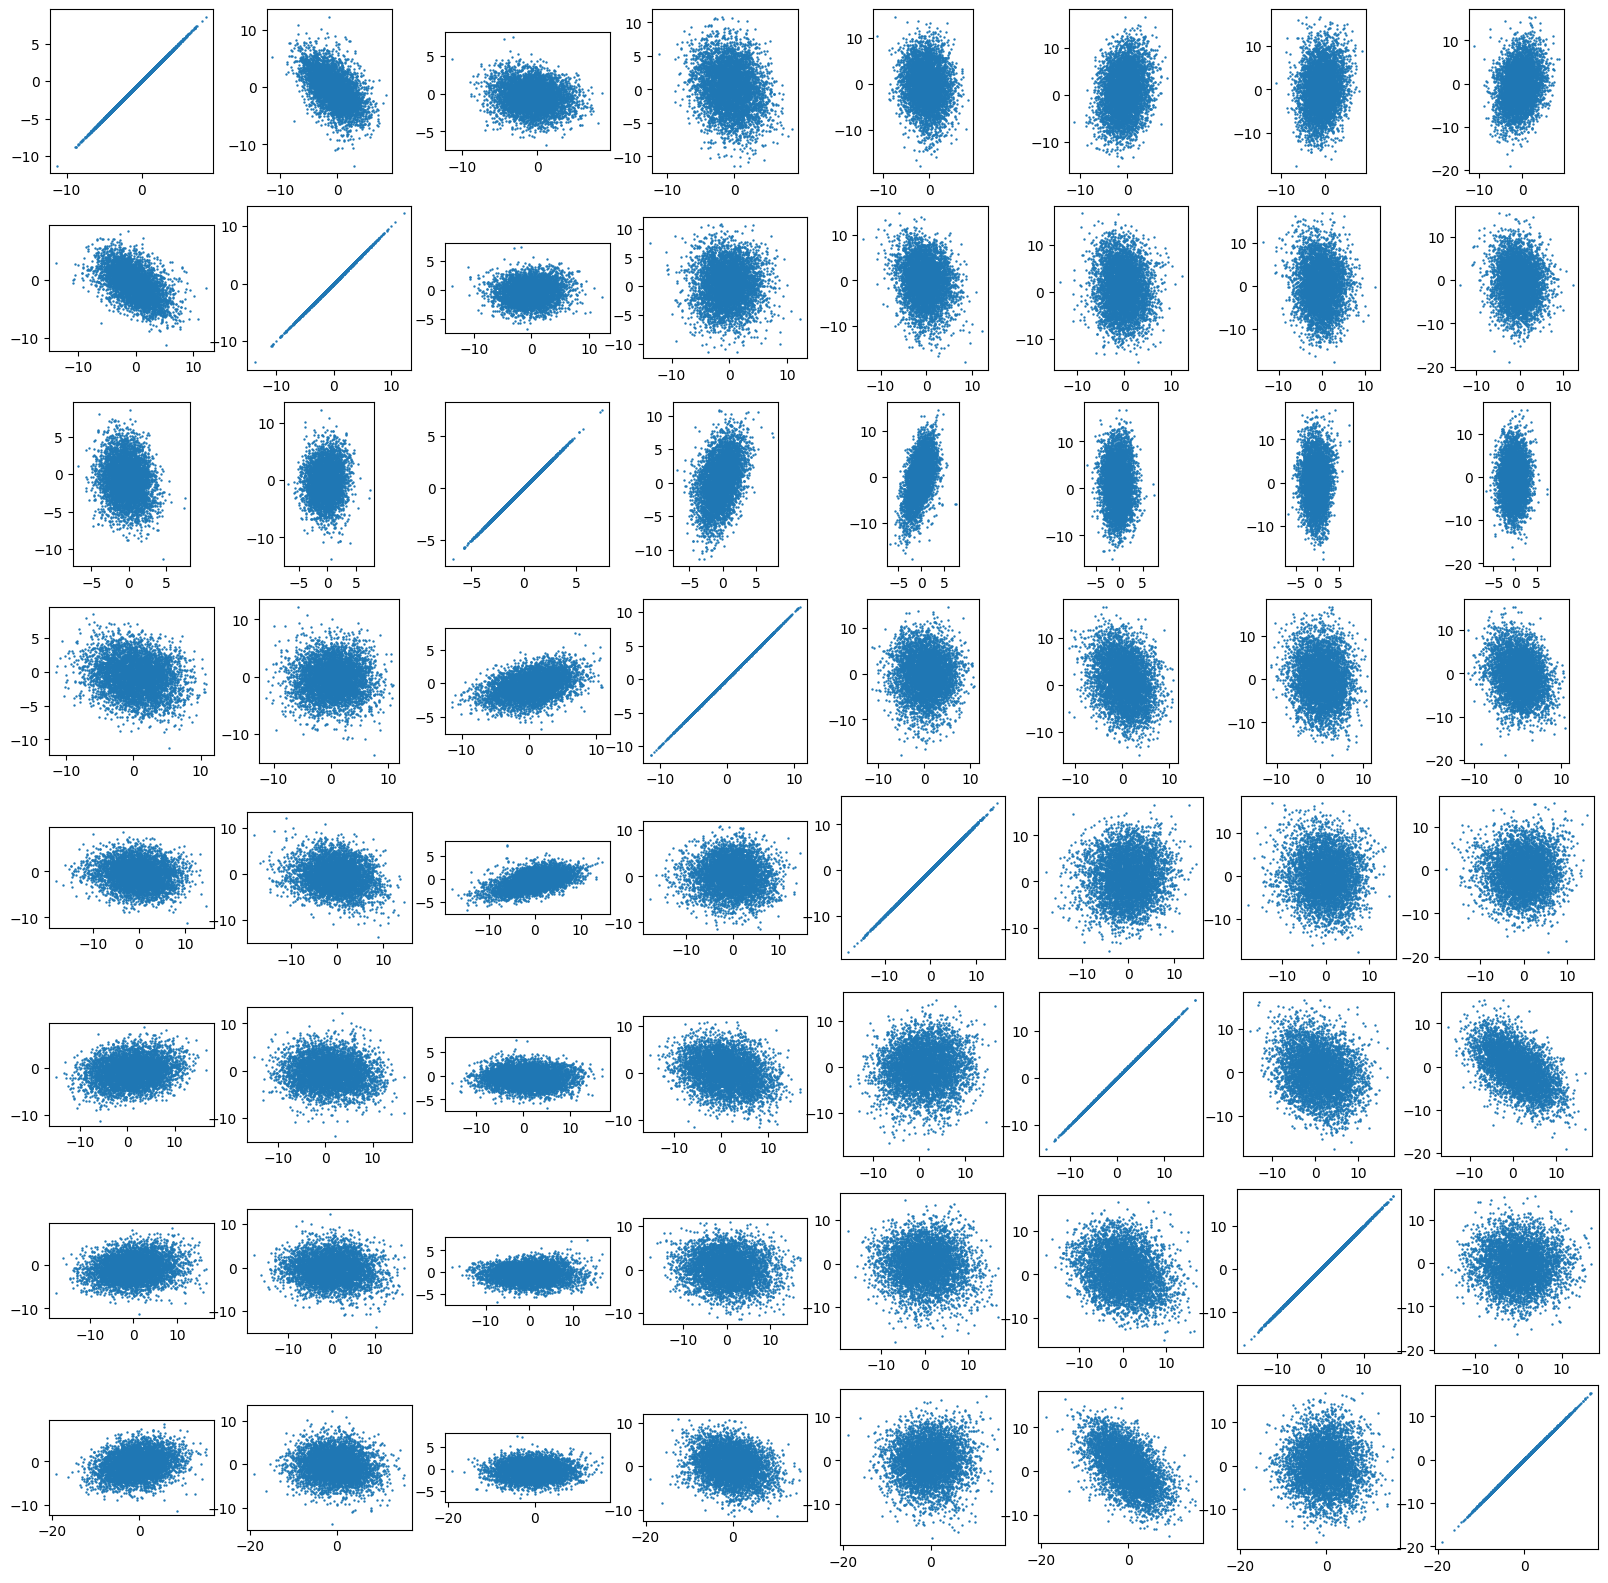

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):

        axs[i][j].scatter(positions[:, i], positions[:, j], 0.5)
        axs[i][j].set_aspect('equal')

plt.show()